In [203]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [204]:
PATH_TO_DATA = "./data/"
imu = pd.read_csv(PATH_TO_DATA + "imu_quadrat.csv", encoding="utf-16")
tab = pd.read_csv(PATH_TO_DATA + "tab_quadrat.csv", encoding="utf-8")
tab = tab.drop([386, 3551]) # these values contain the header (string data)

tab[["x", "y", "z", "pressure"]] = tab[["x", "y", "z", "pressure"]].astype('float')

# handling the host_timestamp values since they are too big 
tab["host_timestamp"] = tab["host_timestamp"].apply(lambda x: int(x[:-2]))
imu["host_timestamp"] = imu["host_timestamp"].apply(lambda x: x // 100)

In [205]:
imu.head(1)

,host_timestamp,arduino_timestamp,ax,ay,az,gx,gy,gz,temperature
0,226624125251,724265,-5.6064,5.9139,-4.9723,-0.0611,-0.1845,-0.0965,24.48


In [206]:
tab.head(1)

,host_timestamp,x,y,z,in_range,touch,pressure,reset
0,196472241368,-67.0,669.0,0.0,0,0,0.0,0


In [207]:
# merge data based on tablet data

t_left, t_right = tab["host_timestamp"].iloc[[0, -1]]
i_left, i_right = imu["host_timestamp"].iloc[[0, -1]]
left = max(t_left, i_left) #later start 
right = min(t_right, i_right) #earlier ending

# use tab data set as base to merge on
df = tab[(tab["host_timestamp"] >= left) & (tab["host_timestamp"] <= right)].copy()

#end_of_writing = df[df["pressure"]> 0.0].tail(1).index[0]
#df = df.iloc[:end_of_writing, :]

# Compute distance
x = df["x"].values
y = df["y"].values
dx = np.diff(x, prepend=x[0])
dy = np.diff(y, prepend=y[0])
d = np.sqrt(dx ** 2 + dy ** 2)
t = np.cumsum(d)
length = t[-1]

data = pd.DataFrame()

# Sample at regular (spatial) interval
data["t_r"] = np.arange(0, length, 0.5)
print("The new length of the dataframe is {}".format(len(data["t_r"])))


The new length of the dataframe is 15894


In [208]:
# create time spans for interpolation
tab_time_span = np.linspace(np.min(df["host_timestamp"].values), np.max(df["host_timestamp"].values), len(data))
imu_time_span = np.linspace(np.min(imu["host_timestamp"].values), np.max(imu["host_timestamp"].values), len(data))

# interpolate tablet data
for column in ['x', 'y', 'z', 'pressure']:
    data[column] = np.interp(tab_time_span, df["host_timestamp"].values, df[column])

# interpolate imu data 
for column in ['ax', 'ay', 'az', 'gx', 'gy', 'gz']:
    data[column] = np.interp(imu_time_span, imu["host_timestamp"].values, imu[column])

In [209]:
data.head(2)

,t_r,x,y,z,pressure,ax,ay,az,gx,gy,gz
0,0.0,-212.0,814.0,0.0,0.0,-5.6064,5.913900,-4.972300,-0.061100,-0.184500,-0.096500
1,0.5,-212.0,814.0,0.0,0.0,-5.5962,5.916582,-4.919521,-0.019449,-0.163674,-0.163563


In [210]:
import plotly.graph_objects as go

def plot_trace(x,y,z,t):
    # Create the 3D scatter plot
    fig = go.Figure(data=go.Scatter3d(
        x=x_values,
        y=y_values,
        z=z_values,
        mode='markers',
        marker=dict(
            size=5,
            color=timestamps,
            colorscale='viridis',
            colorbar=dict(title='Time')
        )
    ))

    # Set plot title and axis labels
    fig.update_layout(
        title='Position Trace over Time',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        )
    )

    # Display the interactive plot
    fig.show()

# visualize data
x_values = data.x  
y_values = data.y 
timestamps = data.t_r 
z_values = data.z
plot_trace(x_values, y_values, z_values, timestamps)

In [211]:
# erase noisy data from beginning and end
data = data[data.index > 1000]
data = data[data.index < 14000]

# visualize data
x_values = data.x  
y_values = data.y 
timestamps = data.t_r 
z_values = data.z
plot_trace(x_values, y_values, z_values, timestamps)

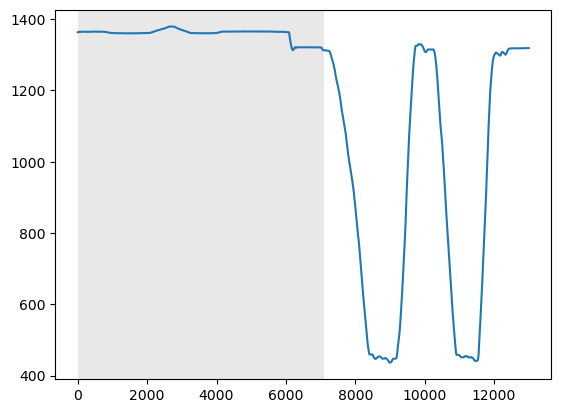

In [212]:
# seperate calibration data from drawing data
def find_first_drop():
    indices = data.index.to_list()
    for i in range(1,len(indices)-1):
        curr = data.loc[indices[i],"x"] + 1
        prev = data.loc[indices[i-1],"x"]
        if curr < prev:
         return indices[i]
    return 0
fd = find_first_drop()
# Color the background before the threshold x value
plt.axvspan(0, fd, facecolor='lightgrey', alpha=0.5)
plt.plot(range(len(data)), data.x)

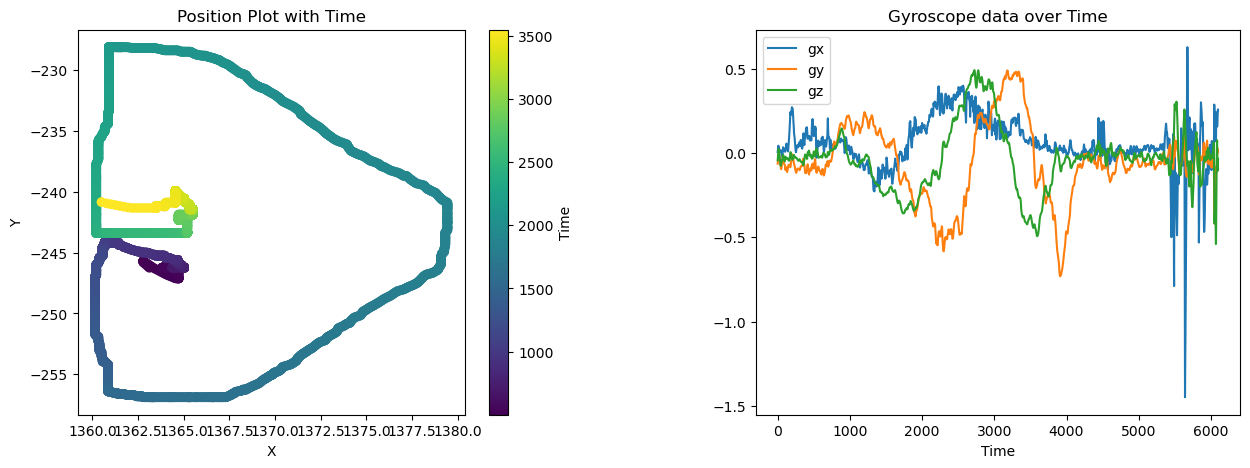

In [213]:
# plot calibration data
calibration_data = data[data.index < fd]
x_values = calibration_data.x  
y_values = calibration_data.y 
timestamps = calibration_data.t_r 
z_values = calibration_data.z
# Create the figure and axes for the subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot for x and y values with color-coded points
scatter = ax1.scatter(x_values, y_values, c=timestamps, cmap='viridis')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Position Plot with Time')
plt.colorbar(scatter, ax=ax1, label='Time')

# Plot for x values over time
ax2.plot(range(len(calibration_data)), calibration_data.gx, label = "gx")
ax2.plot(range(len(calibration_data)), calibration_data.gy, label = "gy")
ax2.plot(range(len(calibration_data)), calibration_data.gz, label = "gz")
ax2.set_xlabel('Time')
ax2.legend()
ax2.set_title('Gyroscope data over Time')

# Adjust spacing between the subplots
plt.subplots_adjust(wspace=0.4)

# Display the plot
plt.show()

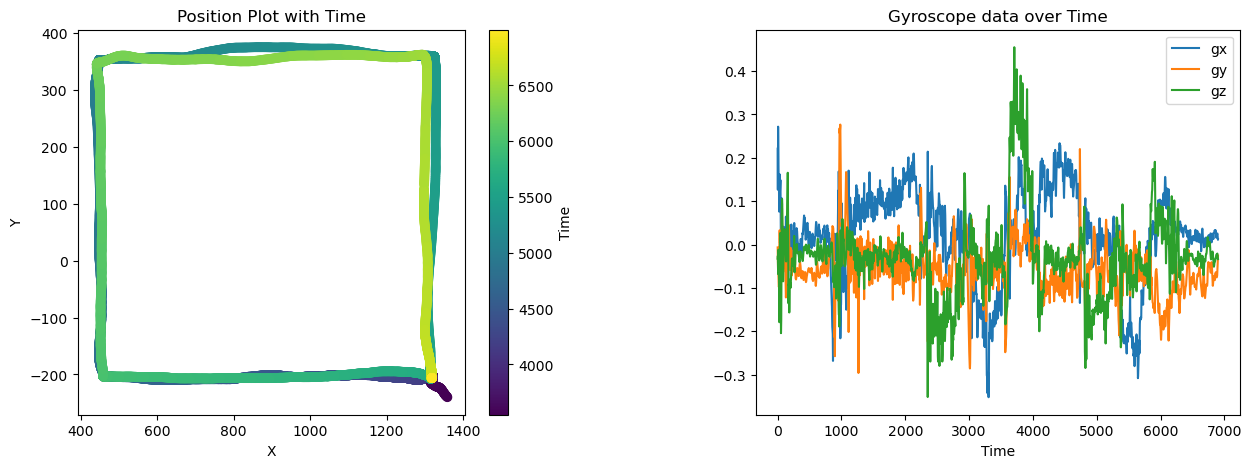

In [214]:
# plot rectangle data data
rectangle_data = data[data.index >= fd]
x_values = rectangle_data.x  
y_values = rectangle_data.y 
timestamps = rectangle_data.t_r 
z_values = rectangle_data.z
# Create the figure and axes for the subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot for x and y values with color-coded points
scatter = ax1.scatter(x_values, y_values, c=timestamps, cmap='viridis')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Position Plot with Time')
plt.colorbar(scatter, ax=ax1, label='Time')

# Plot for x values over time
ax2.plot(range(len(rectangle_data)), rectangle_data.gx, label = "gx")
ax2.plot(range(len(rectangle_data)), rectangle_data.gy, label = "gy")
ax2.plot(range(len(rectangle_data)), rectangle_data.gz, label = "gz")
ax2.set_xlabel('Time')
ax2.legend()
ax2.set_title('Gyroscope data over Time')

# Adjust spacing between the subplots
plt.subplots_adjust(wspace=0.4)

# Display the plot
plt.show()

In [215]:
from numpy.linalg import norm    
def rotation_matrix(q):
    # divide by norm so we have a unit quaternion
    q0 = q[0] / norm(q)
    q1 = q[1] / norm(q)
    q2 = q[2] / norm(q)
    q3 = q[3] / norm(q)

    R = np.zeros((3,3))
    
    R[0,0] = 1- 2 * (q2 * q2 + q3 * q3) 
    R[0,1] = 2 * (q1 * q2 - q0 * q3)
    R[0,2] = 2 * (q1 * q3 + q0 * q2)
    
    R[1,0] = 2 * (q1 * q2 + q0 * q3)
    R[1,1] = 1 - 2 * (q1 * q1 + q3 * q3) 
    R[1,2] = 2 * (q2 * q3 - q0 * q1)
    
    R[2,0] = 2 * (q1 * q3 - q0 * q2)
    R[2,1] = 2 * (q2 * q3 + q0 * q1)
    R[2,2] = 1 - 2 * (q1 * q1 + q2 * q2) 

    # inverse of R is body to global, matrix is orthogonal so transpose is equal to inverse                  
    return np.transpose(R)

In [216]:
import ahrs
from scipy.spatial.transform import Rotation

def calculate_position(acceleration, dt):
    velocity = np.zeros_like(acceleration)
    position = np.zeros_like(acceleration)

    for i in range(1, len(acceleration)):
        velocity[i] = velocity[i-1] + acceleration[i] * dt
        position[i] = position[i-1] + velocity[i] * dt

    return position

# Sample data
acceleration_sensor = rectangle_data[["ax", "ay", "az"]].to_numpy() 
gyroscope_sensor = rectangle_data[["gx", "gy", "gz"]].to_numpy()  
dt = 0.5  # Time interval between measurements

# Initialize the Madgwick filter
madgwick_filter = ahrs.filters.Madgwick()
madgwick_filter.Dt = dt

# Perform sensor fusion with Madgwick filter
orientation = np.tile(ahrs.common.orientation.acc2q(acceleration_sensor[0]), (len(gyroscope_sensor), 1))
for i in range(1, len(gyroscope_sensor)):
    orientation[i] = madgwick_filter.updateIMU(orientation[i-1],gyroscope_sensor[i], acceleration_sensor[i])


# Transform acceleration to the inertial frame using the estimated orientation
acceleration_inertial = np.zeros_like(acceleration_sensor)
for i in range(len(acceleration_sensor)):
    rotation = rotation_matrix(orientation[i])
    acceleration_inertial[i] = rotation @ acceleration_sensor[i]

# Calculate position using dead reckoning
position = calculate_position(acceleration_inertial, dt)
print(position)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.54796501e-01  2.38641274e+00  2.03849588e-01]
 [-4.21958115e-01  7.13937489e+00  4.69615426e-01]
 ...
 [ 5.76925103e+06 -1.20530849e+06  4.22706506e+06]
 [ 5.77081259e+06 -1.20487831e+06  4.22764217e+06]
 [ 5.77237296e+06 -1.20444611e+06  4.22821863e+06]]


In [217]:
import ahrs
from scipy.spatial.transform import Rotation

def calculate_position(acceleration, dt):
    velocity = np.zeros_like(acceleration)
    position = np.zeros_like(acceleration)

    for i in range(1, len(acceleration)):
        velocity[i] = velocity[i-1] + acceleration[i] * dt
        position[i] = position[i-1] + velocity[i] * dt

    return position

# Sample data
acceleration_sensor = rectangle_data[["ax", "ay", "az"]].to_numpy() 
gyroscope_sensor = rectangle_data[["gx", "gy", "gz"]].to_numpy()  
dt = 0.5  # Time interval between measurements

# Initialize the Madgwick filter
madgwick_filter = ahrs.filters.Madgwick()
madgwick_filter.Dt = dt

# Perform sensor fusion with Madgwick filter
orientation = np.tile(ahrs.common.orientation.acc2q(acceleration_sensor [0]), (len(gyroscope_sensor), 1))
for i in range(1, len(gyroscope_sensor)):
    orientation[i] = madgwick_filter.updateIMU(orientation[i-1],gyroscope_sensor[i], acceleration_sensor[i])


# Transform acceleration to the inertial frame using the estimated orientation
acceleration_inertial = np.zeros_like(acceleration_sensor)
for i in range(len(acceleration_sensor)):
    rotation = Rotation.from_quat(orientation[i])
    acceleration_inertial[i] = rotation.apply(acceleration_sensor[i])

# Calculate position using dead reckoning
position = calculate_position(acceleration_inertial, dt)
print(position)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.19274090e-02  2.09831749e-01 -2.38950641e+00]
 [ 2.09159751e-01  5.99547257e-01 -7.14176652e+00]
 ...
 [-1.37964336e+07  2.15724331e+06 -3.53877158e+07]
 [-1.38002524e+07  2.15745370e+06 -3.53969485e+07]
 [-1.38040729e+07  2.15766493e+06 -3.54061828e+07]]


In [218]:
import ahrs
from scipy.spatial.transform import Rotation

def calculate_position(acceleration, dt):
    velocity = np.zeros_like(acceleration)
    position = np.zeros_like(acceleration)

    for i in range(1, len(acceleration)):
        velocity[i] = velocity[i-1] + acceleration[i] * dt
        position[i] = position[i-1] + velocity[i] * dt

    return position

# Sample data
acceleration_sensor = rectangle_data[["ax", "ay", "az"]].to_numpy() 
gyroscope_sensor = rectangle_data[["gx", "gy", "gz"]].to_numpy()  
dt = 0.5  # Time interval between measurements

# Initialize the Mahony filter
# sample frequency is 100 Hz
mahony_filter = ahrs.filters.Mahony(k_P=1, ki=0.3, frequency=2)
mahony_filter.Dt = dt

# Perform sensor fusion with Madgwick filter
orientation = np.tile(ahrs.common.orientation.acc2q(acceleration_sensor[0]), (len(gyroscope_sensor), 1))
for i in range(1, len(gyroscope_sensor)):
    orientation[i] = mahony_filter.updateIMU(orientation[i-1],gyroscope_sensor[i], acceleration_sensor[i])


# Transform acceleration to the inertial frame using the estimated orientation
acceleration_inertial = np.zeros_like(acceleration_sensor)
for i in range(len(acceleration_sensor)):
    rotation = Rotation.from_quat(orientation[i])
    acceleration_inertial[i] = rotation.apply(acceleration_sensor[i])

# Calculate position using dead reckoning
position = calculate_position(acceleration_inertial, dt)
print(position)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 7.01274806e-02  1.52587097e-01 -2.39421838e+00]
 [ 1.86076976e-01  4.59720772e-01 -7.15297296e+00]
 ...
 [ 3.40365081e+06  6.95103989e+06 -5.62809478e+07]
 [ 3.40489835e+06  6.95314658e+06 -5.62971696e+07]
 [ 3.40614619e+06  6.95525334e+06 -5.63133938e+07]]


In [219]:
import ahrs

def calculate_position(acceleration, dt):
    velocity = np.zeros_like(acceleration)
    position = np.zeros_like(acceleration)

    for i in range(1, len(acceleration)):
        velocity[i] = velocity[i-1] + acceleration[i] * dt
        position[i] = position[i-1] + velocity[i] * dt

    return position

# Sample data
acceleration_sensor = rectangle_data[["ax", "ay", "az"]].to_numpy() / 9.81
gyroscope_sensor = rectangle_data[["gx", "gy", "gz"]].to_numpy()  
dt = 0.5  # Time interval between measurements

# Initialize the Mahony filter
# sample frequency is 100 Hz
mahony_filter = ahrs.filters.Mahony(k_P=1, ki=0.3, frequency=2)
mahony_filter.Dt = dt

gyro_bias_drift = np.array([0.04, 0.03, -0.07]) #np.array([0.04, 0.03, -0.07]) #[0.041,  0.031, - 0.0755]

# Perform sensor fusion with Madgwick filter
orientation = np.tile(ahrs.common.orientation.acc2q(acceleration_sensor[0]), (len(gyroscope_sensor), 1))
for i in range(1, len(gyroscope_sensor)):
    gyroscope_with_bias = gyroscope_sensor[i] + gyro_bias_drift * dt
    orientation[i] = mahony_filter.updateIMU(orientation[i-1],gyroscope_with_bias, acceleration_sensor[i])


# Transform acceleration to the inertial frame using the estimated orientation
acceleration_inertial = np.zeros_like(acceleration_sensor)
for i in range(len(acceleration_sensor)):
    rotation = rotation_matrix(orientation[i])
    acceleration_inertial[i] = (rotation @ acceleration_sensor[i]) 

# Calculate position using dead reckoning
position = calculate_position(acceleration_inertial, dt)
print(position)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.59494389e-02  2.43630149e-01  1.57409623e-02]
 [-4.72485917e-02  7.28361632e-01  3.02304223e-02]
 ...
 [ 6.81573153e+05 -5.61211582e+03 -3.46460276e+05]
 [ 6.81824144e+05 -5.69821534e+03 -3.46507946e+05]
 [ 6.82075127e+05 -5.78409330e+03 -3.46555730e+05]]


In [220]:
x_values = position[:,0] 
y_values = position[:,1] 
z_values = position[:,2] 
plot_trace(x_values, y_values, z_values, timestamps)

In [221]:
# Initial gyroscope bias drift
gyro_bias_drift = np.array([0.04, 0.03, -0.07])


# Define cost function
def cost_function(gyro_bias_drift):
    orientation = np.tile(ahrs.common.orientation.acc2q(acceleration_sensor[0]), (len(gyroscope_sensor), 1))
    for i in range(1, len(gyroscope_sensor)):
        gyroscope_with_bias = gyroscope_sensor[i] + gyro_bias_drift * dt
        orientation[i] = mahony_filter.updateIMU(orientation[i-1],gyroscope_with_bias, acceleration_sensor[i])


    # Transform acceleration to the inertial frame using the estimated orientation
    acceleration_inertial = np.zeros_like(acceleration_sensor)
    for i in range(len(acceleration_sensor)):
        rotation = rotation_matrix(orientation[i])
        acceleration_inertial[i] = (rotation @ acceleration_sensor[i]) - np.array([0,0,1])

    # Calculate position using dead reckoning
    position = calculate_position(acceleration_inertial, dt)
    # Calculate the squared difference between initial and final positions
    cost = np.sum((position[0,] - position[-1,])**2)
    cost = np.sum(position[:,1])
    print(cost)
    return cost

# Define gradient of the cost function
def gradient(gyro_bias_drift):
    epsilon = 0.01  # Small value for numerical stability
    grad = np.zeros_like(gyro_bias_drift)
    for i in range(len(gyro_bias_drift)):
        # Calculate the partial derivative numerically using central difference approximation
        gyro_bias_drift_plus = np.copy(gyro_bias_drift)
        gyro_bias_drift_plus[i] += epsilon
        gyro_bias_drift_minus = np.copy(gyro_bias_drift)
        gyro_bias_drift_minus[i] -= epsilon
        cost_plus = cost_function(gyro_bias_drift_plus)
        cost_minus = cost_function(gyro_bias_drift_minus)
        grad[i] = (cost_plus - cost_minus) / (2 * epsilon)
    return grad

# Optimization using gradient descent
learning_rate = 0.01  # Adjust the learning rate as needed
max_iterations = 20  # Maximum number of iterations
tolerance = 0.000001

for iteration in range(max_iterations):
    print("iteration:", iteration)
    # Calculate the current cost and gradient
    current_cost = cost_function(gyro_bias_drift)
    current_gradient = gradient(gyro_bias_drift)

    # Update the gyroscope bias drift using gradient descent
    gyro_bias_drift -= learning_rate * current_gradient

    # Check convergence by comparing the cost function value
    if np.abs(cost_function(gyro_bias_drift) - current_cost) < tolerance:
        break

print("Optimized Gyroscope Bias Drift:", gyro_bias_drift)


iteration: 0
596709484.3266737
-1069824893.0931053
183663458.65081906
433501649.5219115
1050221665.9545825
545549694.0720199
982836231.043204
2884703906.142865
iteration: 1
2884703906.142865
2884703906.0780168
2884703906.2076955


KeyboardInterrupt: 

In [ ]:
# tansform tablet pixel data to m 

tablet_width_mm = 216.0
tablet_height_mm = 135.0
tablet_lpi = 2540
display_dpi = 96

# Sample pixel coordinates
x_pixel = 100
y_pixel = 150

# Convert pixel coordinates to meters
x_m = (x_pixel / tablet_lpi) * (25.4 / display_dpi) * tablet_width_mm / 1000
y_m = (y_pixel / tablet_lpi) * (25.4 / display_dpi) * tablet_height_mm / 1000

In [ ]:
# Sample data
acceleration_sensor = calibration_data[["ax", "ay", "az"]].to_numpy() 
gyroscope_sensor = calibration_data[["gx", "gy", "gz"]].to_numpy()  
dt = 0.5  # Time interval between measurements

# Initialize the Mahony filter
# sample frequency is 100 Hz
mahony_filter = ahrs.filters.Mahony(k_P=1, ki=0.3, frequency=2)
mahony_filter.Dt = dt



# Perform sensor fusion with Madgwick filter
orientation = np.tile(ahrs.common.orientation.acc2q(acceleration_sensor[0]), (len(gyroscope_sensor), 1))
A = np.empty((len(gyroscope_sensor), 3, 3))
for i in range(1, len(gyroscope_sensor)):
    gyroscope_with_bias = gyroscope_sensor[i] 
    orientation[i] = mahony_filter.updateIMU(orientation[i-1],gyroscope_with_bias, acceleration_sensor[i])


# Transform acceleration to the inertial frame using the estimated orientation
acceleration_inertial = np.zeros_like(acceleration_sensor)
for i in range(len(acceleration_sensor)):
    rotation = rotation_matrix(orientation[i])
    A[i] = rotation - np.eye(3)
    acceleration_inertial[i] = (rotation @ acceleration_sensor[i]) - np.array([0,0,1])

# Calculate position using dead reckoning
position = calculate_position(acceleration_inertial, dt) 

In [ ]:
A_flat = A.reshape(-1, 9)
# Solve the least squares problem
x, residuals, rank, singular_values = np.linalg.lstsq(A_flat, position, rcond=None)

In [ ]:
x

array([[ 2.32605143e+05,  5.52768819e+04, -5.89199918e+04],
       [ 5.30397690e+03,  1.37494670e+04, -4.38001768e+04],
       [-6.14201942e+06, -3.08151241e+06,  3.72948665e+06],
       [ 1.13256946e+06,  4.86362482e+05, -5.04297087e+05],
       [ 2.03577273e+06,  5.37414496e+05, -8.62829282e+05],
       [ 6.76895442e+05,  3.79712914e+05, -3.36683864e+05],
       [-2.17788113e+06, -6.33264284e+05,  9.84597795e+05],
       [ 9.45173872e+05,  3.30637307e+05, -3.42525147e+05],
       [ 1.43295640e+06,  7.65772673e+05, -9.18363073e+05]])